# Deep Learning in the Laser Lab: Analysis of Ultrafast Organometallic Molecular Fragmentation

# Outline
1. Introduction
2. Data sampling
3. Data cleaning and preprocessing
4. Data exploration and visualization
5. Fitting to a deep convnet
6. Getting insights from the model
7. Conclusions

# 1. Introduction

Here we analyze data from laser fragmentation experiments. In the experiments, the organometallic molecule Pr(fac)$_3$ was irradiated by femtosecond laser pulses with different shapes. As a result, the molecule is broken into fragments (i.e., themselves other molecules or atoms). The fragment amounts are measured by a mass spectrometer yielding proportional voltage signals. The experimental data thus consists on the fragment signals as a function of pulse shape parameters.

We start with some considerations regarding data sampling (i.e., what laser pulse shapes need to be measured) in order to obtain a balanced dataset. The data is then cleaned and pre-processed before being fed into a deep convolutional neural network (CNN). Finally, insights are extracted from the trained CNN model.

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data sampling

In [2]:
df = pd.read_csv("data/raw_lab_data.csv")
df.head()

time stamp   pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5  \
0  1.488395e+09  2.991791  2.991791  2.991791  2.991791  3.959783  3.959783   
1  1.488395e+09  4.000777  4.000777  4.000777  4.000777  1.033685  1.033685   
2  1.488395e+09  2.760840  2.760840  2.760840  2.760840  0.327022  0.327022   
3  1.488395e+09  4.355489  4.355489  4.355489  4.355489  2.505186  2.505186   
4  1.488395e+09  4.184372  4.184372  4.184372  4.184372  3.150066  3.150066   

    pixel_6   pixel_7   pixel_8    ...     PrF(rfac)  PrF2(rfac)   Pr(fac)  \
0  3.959783  3.959783  2.538162    ...      0.944209    2.147477  0.755563   
1  1.033685  1.033685  4.118185    ...      0.954830    2.015553  0.660647   
2  0.327022  0.327022  4.809604    ...      0.826364    2.208652  0.690348   
3  2.505186  2.505186  5.979644    ...      0.862257    2.778266  0.824003   
4  3.150066  3.150066  2.394309    ...      1.004260    2.289058  0.993889   

        355  PrF(fac)  Pr(fac)HCO  PrF(fac)(rfac)  Pr(fac)2  Pr(fac)3  \
0  0.890237  1.850989    1.697434        1.414999  1.124355  0.858919   
1  0.908450  1.506632    1.342852        1.402465  1.190225  0.942872   
2  0.826832  1.960608    1.514259        1.461740  1.213036  0.861299   
3  0.762087  2.296081    2.191945        1.782917  1.492505  0.869206   
4  0.938901  2.108723    1.562883        1.462310  1.340668  0.896058   

        SHG  
0  0.149029  
1  0.142016  
2  0.157935  
3  0.169678  
4  0.148342  

[5 rows x 658 columns]

## 2.1 Laser pulse parameter inputs (X)

The independent variables controlling the laser shape in the raw experimental data correspond to 640 phases. Each phase value determined the laser phase within a 0.2-nm-wide spectral interval (pixel). During the experiments, groups of 4 contiguous pixels were bundled together, resulting in 160 independent variables.

Text(0,0.5,'phase (rad)')

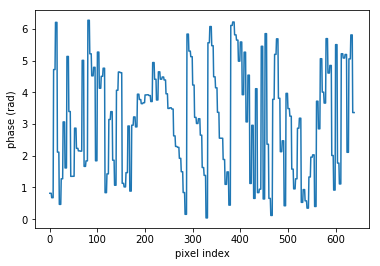

In [7]:
x_cols = [x for x in df.columns if ('pixel' in x)]
s_temp = pd.Series(data = df[x_cols].iloc[-1].values, index=range(640))
s_temp.plot()
plt.xlabel("pixel index")
plt.ylabel("phase (rad)")

## 2.2 Molecular fragmentation signal labels (y)

Text(0,0.5,'fragment signal')

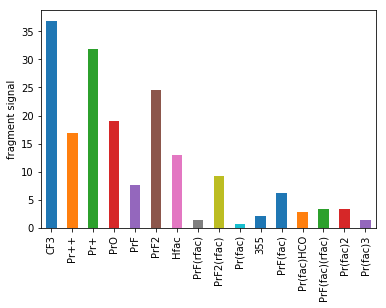

In [8]:
cols = [x for x in df.columns if ('time' not in x) and ('pixel' not in x) and ("SHG" not in x)]
s = df[cols].iloc[-1]
s.plot(kind='bar')
plt.ylabel("fragment signal")

Not shown is the also measured second harmonic generation (SHG) signal that quantifies the square laser intensity. 

The shown raw fragment signals above are close to the maximum signals achievable under the experimental conditions.

## 2.3 Random sampling

Sample signals for the Pr+ fragment approximately corresponding to random laser phases are shown below.

Text(0.5,0,'sample number')

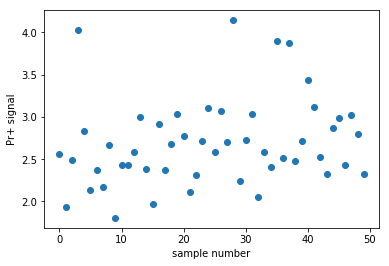

In [13]:
from data_cleaning import split_data_ref

# need to first remove a reference taken along the data (as explained below)
data, ref = split_data_ref(df.values, 640 * [0], slice(1, 641))
df_noref = pd.DataFrame(data=data, columns=df.columns)

df_noref["Pr+"].iloc[0:50].plot(style='o')
plt.ylabel("Pr+ signal")
plt.xlabel("sample number")

Contrast these relatively small values with the value of 32 shown above for the Pr$^+$ signal. Applying random laser phases results mostly in fragment signals close to their minimum.

## 2.4 More balanced sampling

A more balanced dataset was obtained by recording all the fragment measurements taken during a signal optimization (i.e., through altering the pixel phases) carried by a genetic algorithm (GA). To ensure a smooth climb from minimum to maximum signals:
- The GA was set to optimize the SHG signal. SHG is strongly correlated to the fragment signals and its relatively low field order (i.e., second-order) results in a tendency for gradual signal increases during an optimization.
- The GA parameters were modified to favor slow signal increases. Mainly, small mutation rates were used and a relatively large population induced better exploration by the algorithm.

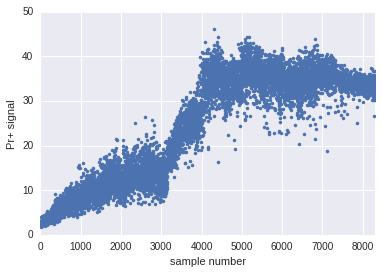

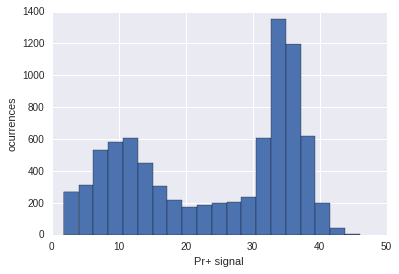

In [29]:
from data_cleaning import split_data_ref

# need to first remove a reference taken along the data (as explained below)
data, ref = split_data_ref(df.values, 640 * [0], slice(1, 641))
df_noref = pd.DataFrame(data=data, columns=df.columns)

plt.figure('sig')
df_noref["Pr+"].plot(style='.')
plt.ylabel("Pr+ signal")
plt.xlabel("sample number")
plt.figure('hist')
df_noref["Pr+"].hist(bins=20)
plt.xlabel("Pr+ signal")
plt.ylabel("ocurrences")

Thus, in contrast to the random phase sampling described above, recording the optimization signals allows measuring relatively well distributed samples ranging from their minimum to approximately their maximum values. The dataset is still somewhat imbalanced. An algorithm for obtaining optimally sampled data (i.e., under a given context, including many potential limitations) will be shared in another repository.

As per the optimization process, the signals tend to increase as the sample number increases. The slight decrease observed by the end of the optimization is related to a slow drift present in the signals (due to imperfections in the experimental system), as described below.

# 3. Data cleaning and preprocessing

In [16]:
df = pd.read_csv("data/raw_lab_data.csv")
print df.shape

(8515, 658)


## 3.1 Signal drift removal

In order to monitor non intended changes in the experimental signals a reference was taken every 60 seconds. The reference consisted in measuring all the fragment signals and SHG for the same laser pulse shape. The timestamps for all measurements (including the reference) were also recorded. Thus, it is possible to expose time resolved changes in the experimental system that are not related to the laser pulse shape.

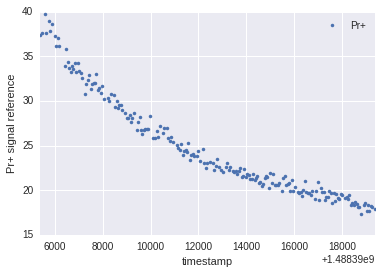

In [25]:
from data_cleaning import split_data_ref

data, ref = split_data_ref(df.values, 640 * [0], slice(1, 641))
df_ref = pd.DataFrame(data=ref, columns=df.columns)

plt.figure('sig')
df_ref.plot(x='time stamp', y='Pr+', style='.')
plt.ylabel("Pr+ signal reference")
plt.xlabel("timestamp")

The fragment signals decayed over time during data collection. The source of the decay was  traced back to a slow reduction in the vapor pressure of Pr(fac)$_3$, resulting on a reduction of the number of molecules available for laser fragmentation. The signal distortions were then linear in nature and, thus, easily correctable through normalizing all signals at a given time by their corresponding references.

A smooth spline was fitted to the signal references to interpolate the reference values at all the sample timestamps. The interpolated references were then used to normalize the signals, thus removing the signal drift.

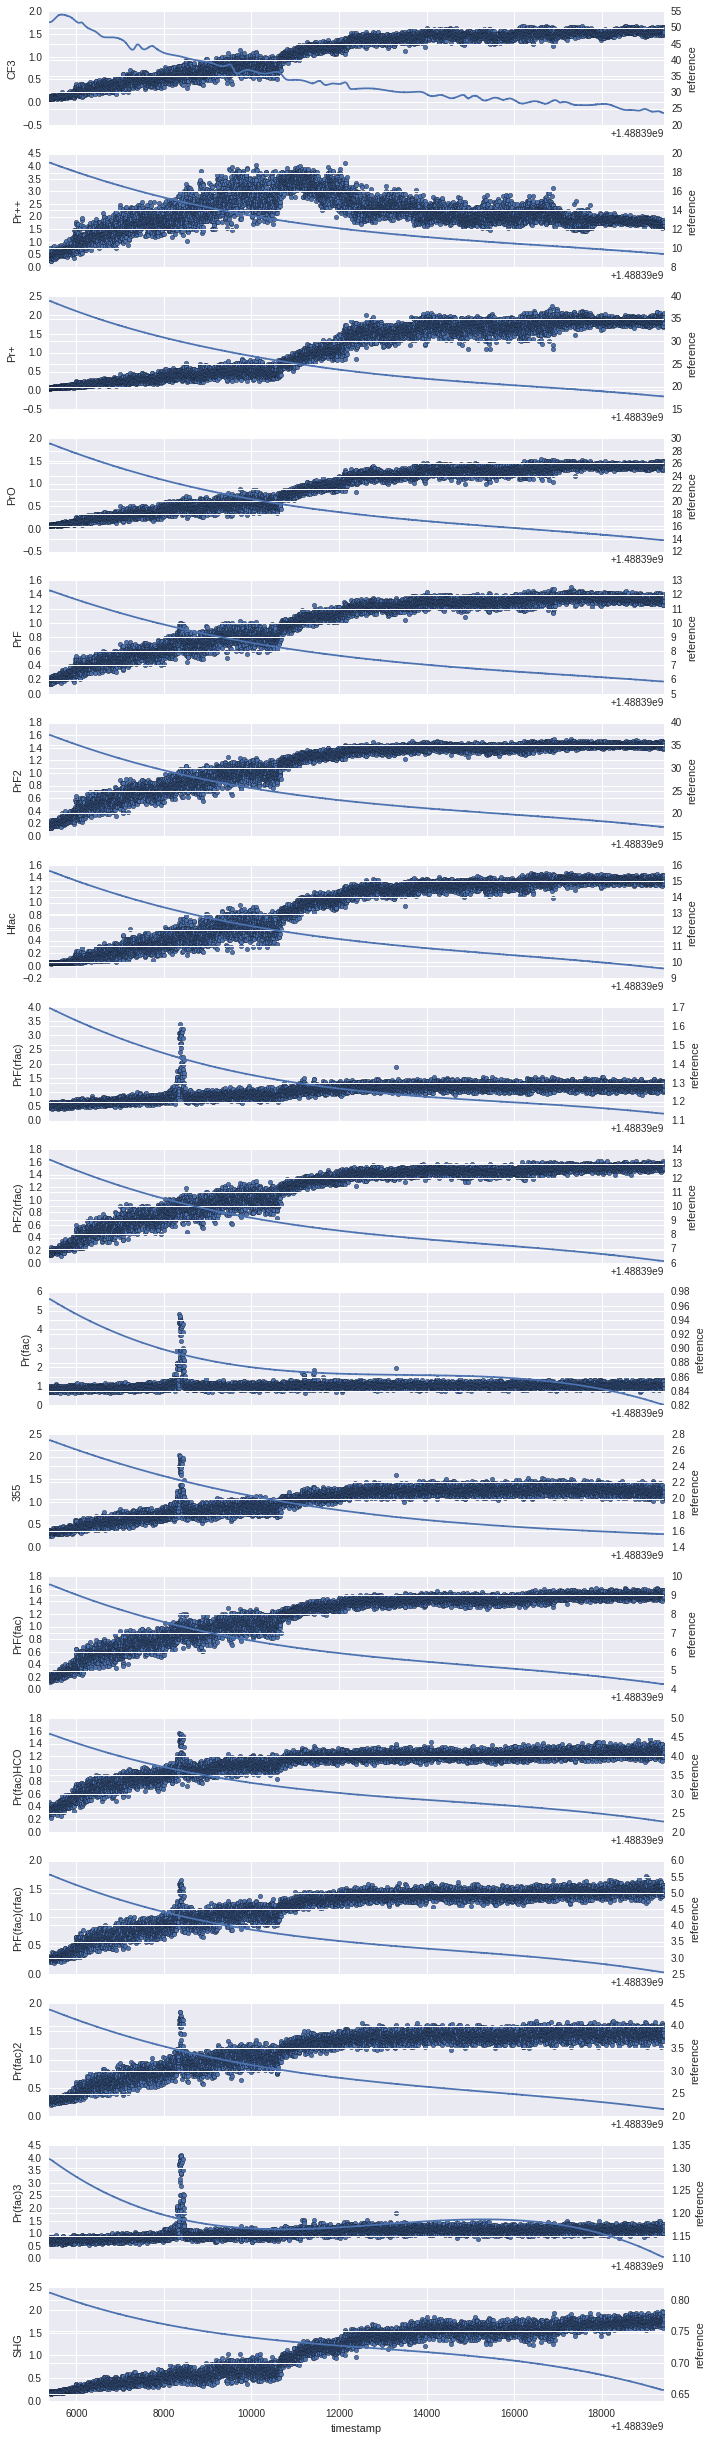

In [31]:
import data_cleaning
from data_cleaning import split_data_ref

data, ref = split_data_ref(df.values, 640 * [0], slice(1, 641))
df_nodrift = data_cleaning.preprocess_data(
    fname='data/raw_lab_data.csv',
    droprows=slice(0, 0),
    Xref=640*[0], 
    Xcols=slice(1, 641),
    tcol=0, 
    ycols=slice(641, None),
    nrolling=20, k=3, s=70,
    figname='cleaning'
)

Removing the drift clearly exposes another experimental artifact after timestamp 8000 + 1.48839e9.

## 3.2 Outlier removal

As shown above,the data points obtained by the GA optimization tend to gradually increase their signal value. Thus, assuming a smooth optimization, spotting outliers in our data becomes easier. Indeed, as mentioned above, an artifact after timestamp 8000 + 1.48839e9 is now clearly exposed.

We take advantage of the fact that the offset-removed signal for Pr(fac) was approximately constant and stable. Thus, it is possible to use Pr(fac) as a convenient proxy for removing outliers. Since the Pr(fac) signal is almost constant, it is possible to approximate it by long-window running averages. The long window is particularly relevant here in order to identify the rather wide artifact after timestamp 8000 + 1.48839e9.

A confidence interval is defined by the running average of Pr(fac) $\pm$ 1.5 times its  standard deviation. Pr(fac) signals outside of this interval are considered outliers.

original shape:  (8312, 674)
outliers removed shape:  (7607, 674)


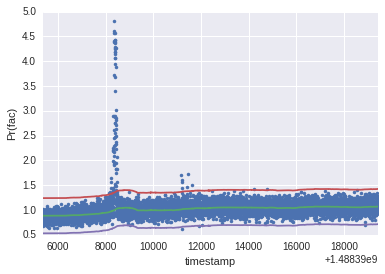

In [135]:
yp = df_nodrift.dropna()["Pr(fac)"]
m = yp.rolling(500).median()
dm = 1.5 * yp.std()

m = m.fillna(method='bfill')
m = m.fillna(method='ffill')

cond = (yp.values > m.values - dm) & (yp.values < m.values + dm)
df_noout = df_nodrift.dropna()[cond]
print "original shape: ", df_nodrift.shape
print "outliers removed shape: ", df_noout.shape

yp.plot(style='.')
m.plot()
(m + dm).plot()
(m - dm).plot()
plt.ylabel("Pr(fac)")

All the resulting outlier-removed signals:

In [ ]:
sig_cols = [x for x in df_noout.columns if ('time' not in x) and ('pixel') not in x]
sig_cols = [x for x in sig_cols if ('ref' not in x)]

for col_name in sig_cols:
    df_noout[col_name].plot()
    plt.xlabel('timestamp')
    plt.ylabel(col_name)
    plt.show()

## 3.3 Removing unnecesary columns

With the processing done above, the timestamp and reference columns are no longer useful. Neither are many of the pixel columns since bundles of 4 have the same values. Will also move the signal columns to the front of the dataset.

In [143]:
xy_cols = [x for x in df_noout.columns if ("reference" not in x) and ("timestamp" not in x)]
sig_cols = [x for x in xy_cols if ("pixel" not in x)]
x_cols = [x for x in xy_cols if ("pixel" in x)][::4]

df_proc = pd.DataFrame()
df_proc[sig_cols] = df_noout.reset_index()[sig_cols]
df_proc[x_cols] = df_noout.reset_index()[x_cols]
df_proc.head()

CF3      Pr++       Pr+       PrO       PrF      PrF2      Hfac  \
0  0.100404  0.523613  0.065823  0.078207  0.197039  0.180334  0.045261   
1  0.085911  0.400526  0.049739  0.066899  0.150506  0.152873  0.049016   
2  0.094576  0.424385  0.064005  0.070912  0.165693  0.171507  0.053706   
3  0.127738  0.565618  0.103516  0.098878  0.237358  0.232615  0.050063   
4  0.103567  0.376046  0.072851  0.078363  0.169927  0.180874  0.048035   

   PrF(rfac)  PrF2(rfac)   Pr(fac)    ...      pixel_600  pixel_604  \
0   0.557313    0.161881  0.779437    ...       1.303925   1.631589   
1   0.563581    0.151936  0.681522    ...       3.278249   6.089047   
2   0.487755    0.166492  0.712161    ...       5.687012   2.622300   
3   0.508941    0.209431  0.850040    ...       4.878788   3.035143   
4   0.592757    0.172554  1.025293    ...       2.779483   5.164510   

   pixel_608  pixel_612  pixel_616  pixel_620  pixel_624  pixel_628  \
0   4.998400   5.106796   1.080035   0.211067   1.171700   0.056230   
1   1.736214   6.269037   6.003611   4.661987   5.874404   5.335451   
2   3.875392   5.775175   5.877297   2.332347   4.620844   3.212228   
3   0.847873   4.829319   5.602847   2.720073   5.065607   1.485614   
4   2.315107   6.268269   3.036830   6.231521   0.168365   4.825293   

   pixel_632  pixel_636  
0   3.717961   2.083975  
1   5.165797   0.295949  
2   0.510081   1.899640  
3   3.354594   6.011468  
4   3.334700   2.061310  

[5 rows x 177 columns]

In [144]:
df_proc.to_csv("data/processed_data.csv", index=False)

# 4. Data exploration and visualization

In [2]:
df = pd.read_csv("data/processed_data.csv")

## 4.1 Correlations among signal labels

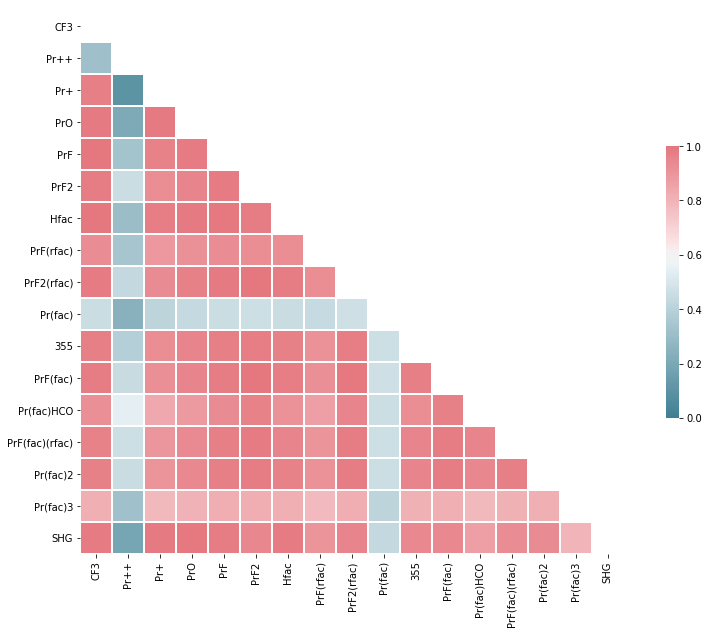

In [37]:
sig_cols = [x for x in df.columns if ("pixel" not in x)]
plt.figure(figsize=(15, 10))

# Generate a mask for the upper triangle
mask = np.zeros_like(df[sig_cols].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(df[sig_cols].corr(), mask=mask, cmap=cmap, 
            vmax=1., vmin=0., center=0.6,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Many of the labels are strongly correlated.

## 4.2 Signal labels sensitivity to the inputs

To see if some inputs could be used to separate the signals, the Pr+ signal is binned into three regions corresponding to low-, medium-, and high-value signals.

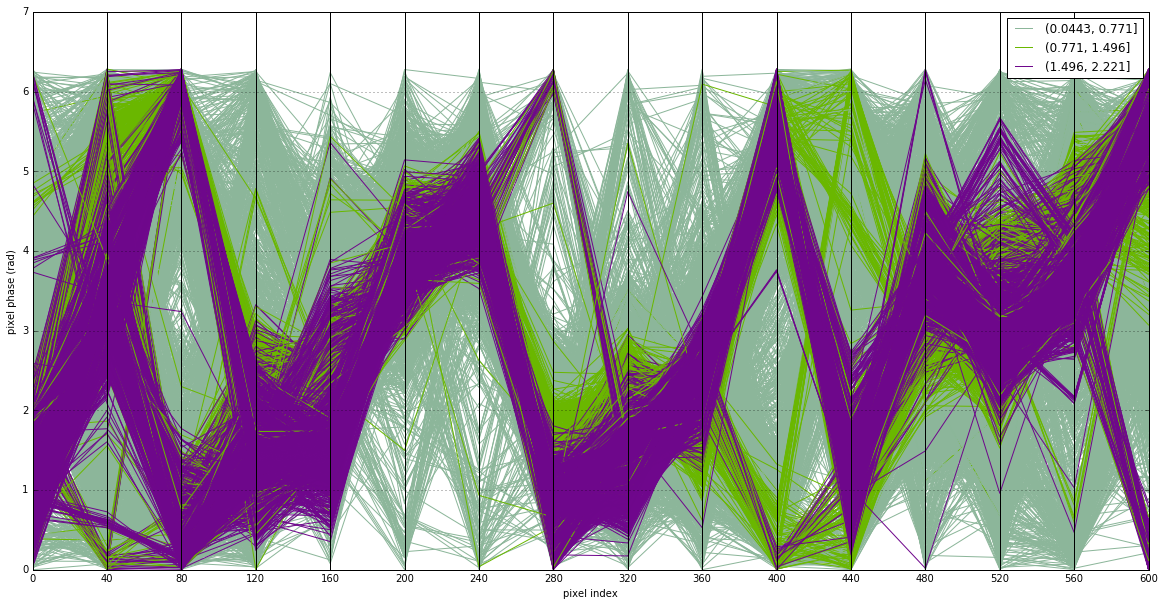

In [16]:
from pandas.plotting import parallel_coordinates

df_temp = pd.DataFrame()
df_temp['Pr+'] = pd.cut(df['Pr+'], bins=3)
x_cols = [x for x in df.columns if ("pixel" in x)]
df_temp[range(0, 4 * len(x_cols), 40)] = df[x_cols[::10]]

plt.figure(figsize=(20, 10))
parallel_coordinates(df_temp, 'Pr+')
plt.xlabel("pixel index")
plt.ylabel("pixel phase (rad)")

No individual pixel seems able to clearly separate the Pr+ signal. In fact, as seen above, most pixel phases result in very low signals. A relatively narrow band of phases results in medium or high value signals.

## 4.3 Input clustering

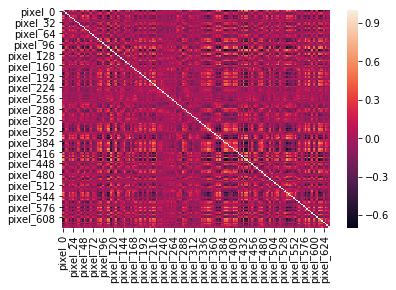

In [4]:
x_cols = [x for x in df.columns if ("pixel" in x)]
sns.heatmap(df[x_cols].corr())

The variables are not fully independent. Diagonalizing the inputs will most likely result in dimensionality reduction.

(0, 700)

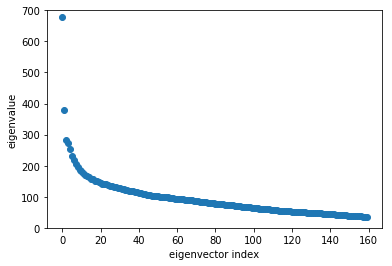

In [8]:
from sklearn.decomposition import PCA

x_cols = [x for x in df.columns if ("pixel" in x)]
pca = PCA(n_components=160)
Xpca = pca.fit_transform(df[x_cols].values)
plt.plot(pca.singular_values_, 'o')
plt.ylabel('eigenvalue')
plt.xlabel('eigenvector index')
plt.ylim((0, 700))

There are two leading component eigenvectors, but contributions from the rest can not be neglected. For the sake of visualization, we take only the two top components below.

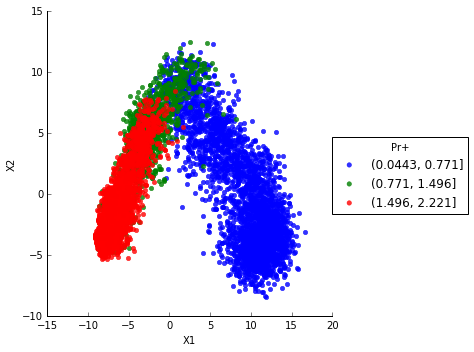

In [39]:
Xpca = PCA(n_components=2).fit_transform(df[x_cols].values)

# scatter plot:
df_temp = pd.DataFrame(data=Xpca, columns=['X1', 'X2'])
df_temp['Pr+'] = pd.cut(df['Pr+'], bins=3)
sns.lmplot('X1', 'X2', data=df_temp, hue='Pr+', fit_reg=False)
plt.xlabel("X1")
plt.ylabel("X2")

PCA does find a level of separation between medium-to-high and low-signals. It is not possible, though, to separate the medium from the high signals by only a linear transformation. The relatively large area (in X1, X2 space) occupied by low- and (to a lesser degree) by high-value signals reflects the fact that there were considerably more samples taken for low- or high-value signals than for mid-value signals (see the Pr+ signal histogram above).

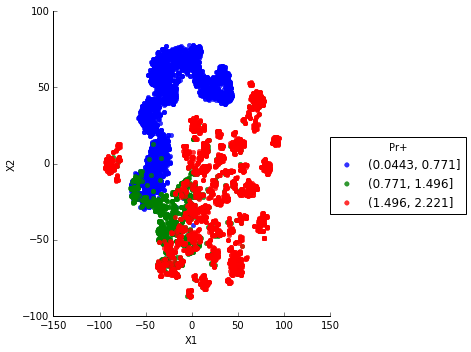

In [38]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Xpca = PCA(n_components=20).fit_transform(df[x_cols].values)
Xtsne = TSNE(n_components=2).fit_transform(Xpca)

# scatter plot:
df_temp = pd.DataFrame(data=Xtsne, columns=['X1', 'X2'])
df_temp['Pr+'] = pd.cut(df['Pr+'], bins=3)
sns.lmplot('X1', 'X2', data=df_temp, hue='Pr+', fit_reg=False)
plt.xlabel("X1")
plt.ylabel("X2")

Notice that the area (in X1, X2 space) for the low-value signals has shrunk under this transformation. Points corresponding to high-value signals now occupy the largest area. This may be understood if we consider that the GA works by continuosly perturbating fields and that high-value fragment signals are very sensitive to laser field perturbations (i.e., the GA is trying to increase the signal and changes towards the high-signal fields consistently produce the largest increases), whereas to obtain a small signal just any random field would do (i.e., there is no consistent field structure, other than complete randomness, that characterizes a low-signal field). Similar arguments could explain why the high-signal areas are 'spotty' (i.e., forming clusters) since the clusters may represent perturbations around a high-value signal field.

The fact that T-SNE is better than PCA in separating the signals suggests that nonlinear transformations may be more adept at fitting the signals.

# 5. Fitting to a deep convnet

## 5.1 Get X and y

In [12]:
df = pd.read_csv("data/processed_data.csv")
x_cols = [x for x in df.columns if ("pixel" in x)]
X = df[x_cols].values
y_cols = [x for x in df.columns if ("pixel" not in x) and ("SHG" not in x)]
y = df[y_cols].values
print X.shape, y.shape

(7607, 160) (7607, 16)


## 5.2 Transform X from phase to real and imaginary parts

Phases can go from -$\infty$ to +$\infty$ which is not exactly convenient for modeling. By transforming to the real and imaginary parts of a unit complex exponential, X will be bounded to the [-1, 1] interval (as generaly needed for working with neural networks).

In [13]:
X = np.exp(1j * X)
X = [np.real(X), np.imag(X)]
X = np.swapaxes(X, 0, -1)
X = np.swapaxes(X, 0, 1)
print X.shape

(7607, 160, 2)


## 5.3 Checking the label values

In [25]:
y_cols = [x for x in df.columns if ("pixel" not in x) and ("SHG" not in x)]
d = {"min": np.min(y, axis=0),
     "mean": np.mean(y, axis=0),
     "max": np.max(y, axis=0)}
pd.DataFrame(d, index=y_cols)

max      mean       min
CF3             1.678924  1.088391  0.066370
Pr++            4.115147  2.143308  0.222779
Pr+             2.221320  1.112291  0.046455
PrO             1.531589  0.912604  0.062653
PrF             1.502453  1.012489  0.134020
PrF2            1.540678  1.139577  0.121618
Hfac            1.472744  0.914964  0.035268
PrF(rfac)       1.543359  1.036028  0.405223
PrF2(rfac)      1.622847  1.171672  0.117128
Pr(fac)         1.400326  1.018114  0.627577
355             1.518813  1.028675  0.255413
PrF(fac)        1.615312  1.173678  0.121097
Pr(fac)HCO      1.469938  1.085673  0.216740
PrF(fac)(rfac)  1.726010  1.177898  0.200967
Pr(fac)2        1.687446  1.162845  0.201502
Pr(fac)3        1.509601  1.038239  0.540342

Ideally, the y columns should also be in the [-1, 1] interval, but this is not a hard requirement particularly for a deep model with multiple layers. The biases can be adjusted gradually during training to fit the labels. What would put an unreasonable stress on the model would be to have very large or positive or negative values. For instance, having label values in the millions may not be possible for certain models (depending in their depth) while still trying to fit changes in the data. Here the labels do not stray far from the [-1, 1] interval. We choose in this case not to scale the labels but the effects of such a choice during model training should be monitored (e.g., by checking the internal inputs and/or gradients using tensorboard).

## 5.4 Train-test split

In [20]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=3)
print Xtrain.shape, Xtest.shape
print ytrain.shape, ytest.shape

(6085, 160, 2) (1522, 160, 2)
(6085, 16) (1522, 16)


## 5.5 Model training

A CNN with five blocks of narrow-filter convolutional layers is trained on the train dataset. The model thus imitates the VGG architecture. One difference is that the number of filters in the conv layers is set to the number of classes (16), instead of increasing as in VGG. Due to the relatively small number of training samples (~6000) the architecture was designed such as to minimize the number of parameters, which are ~13,000 in the current model. Even though the number of parameters are still higher than the number of samples, overfitting is mitigated by the presence of a dropoff layer.

Included at the bottom of the following cell is an instruction to restart the notebook. This is needed since, as of 2018-03, tensorflow won't release the gpu in any other way I know of (e.g., the methods that are supposed to do so do not respond, not just in keras but using tensorflow itself). Comment out the last line if not appropriate.

In [ ]:
import cnn_model
import train
import traceback

try:
    model = cnn_model.model1(
        input_shape = (None, 160, 2),
        conv_blocks = [{'nlayers': 3, 'nfilters': 16, 'kernel_size': 3},
                       {'nlayers': 3, 'nfilters': 16, 'kernel_size': 3},
                       {'nlayers': 3, 'nfilters': 16, 'kernel_size': 3},
                       {'nlayers': 3, 'nfilters': 16, 'kernel_size': 3},
                       {'nlayers': 3, 'nfilters': 16, 'kernel_size': 3},
                      ],
        dense_layers=[16],
        nlabels=16,
        verbose=True,
    )

    train.main(
        model=model,
        train_data=(Xtrain, ytrain), # (X, Y) or function(sample_index, **kwargs) returning (x, y)
        val_data=(Xtest, ytest),
        epochs=1000,
        npoints=Xtrain.shape[0],
        batch_size=512,
        optimizer_name='rmsprop',
        lr=0.0002,
        epsilon=1e-8,
        decay = 0.0002 / 1000, # suggested: lr / epochs
        log_dir='', # empty: saves to tb_logs/current_datetime
        tensorboard_histogram_freq=100,
        ylabels=y_cols,
        verbose=True,
    )
except:
    traceback.print_exc()


# to restart the kernel and release the gpu:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

See "train.py" for details on the training process. Some highlights:
- The learning rate is reduced after each epoch by the amount given as decay.
- Tensorboard-viewable logs are saved. The model graph, gradients, and (if appropriate) images are saved to the log file.
- The last best performing model (on the test data) is saved.
- The train data can be given as a generator to, for instance, stream data that can not fit in memory as batches.

Not shown for brevity are the results of multiple training sessions carried out for parameter tunning. The training and validation loss history plot can suggest changes such as:
- Increase the batch size if the training loss is noisy.
- Decrease the learning rate if the loss goes down suddenly and then levels off.
- Increase the number of epochs if the test loss seems to be able to go further down.
- Increase the learning rate and/or the model complexity (preferably of the conv layers) if the training loss does not go down properly (e.g., if it stays over the test loss).

The relatively high batch size of 512 was chosen because of the observed imbalances in the data (see, e.g., the histogram for Pr+ signals above). A larger batch size insures that some of the less represented signal values are present in each batch. As a result of the large batch size, the number of epochs had to be increased.

The initial learning rate of 0.0005 (instead of the usually recommended value of 0.001) was chosen to slow down the initial decay of the loss. The lower initial learning rate led to a better test loss. Smaller initial learning rates were coupled to proportional increases to the number of epochs. 

## 5.6 Evaluation of the model with lowest test loss

During training the model with the best test loss (which does not necesarily coincide with the last model) was saved. Its performance is shown below.

### Gathering needed information

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/processed_data.csv")
x_cols = [x for x in df.columns if ("pixel" in x)]
X = df[x_cols].values
y_cols = [x for x in df.columns if ("pixel" not in x) and ("SHG" not in x)]
y = df[y_cols].values
print X.shape, y.shape

X = np.exp(1j * X)
X = [np.real(X), np.imag(X)]
X = np.swapaxes(X, 0, -1)
X = np.swapaxes(X, 0, 1)
print X.shape

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=3)
print Xtrain.shape, Xtest.shape
print ytrain.shape, ytest.shape

(7607, 160) (7607, 16)
(7607, 160, 2)
(6085, 160, 2) (1522, 160, 2)
(6085, 16) (1522, 16)


### Loss history and test set truth tables

The last line in the following cell restarts the notebook. Comment out if not appropriate.

Using TensorFlow backend.


6085/6085 [==============================] - 1s 131us/step


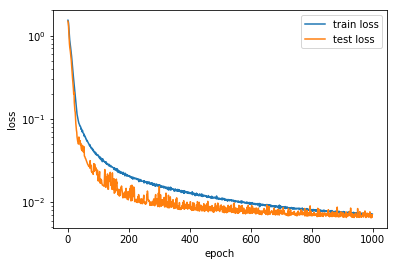

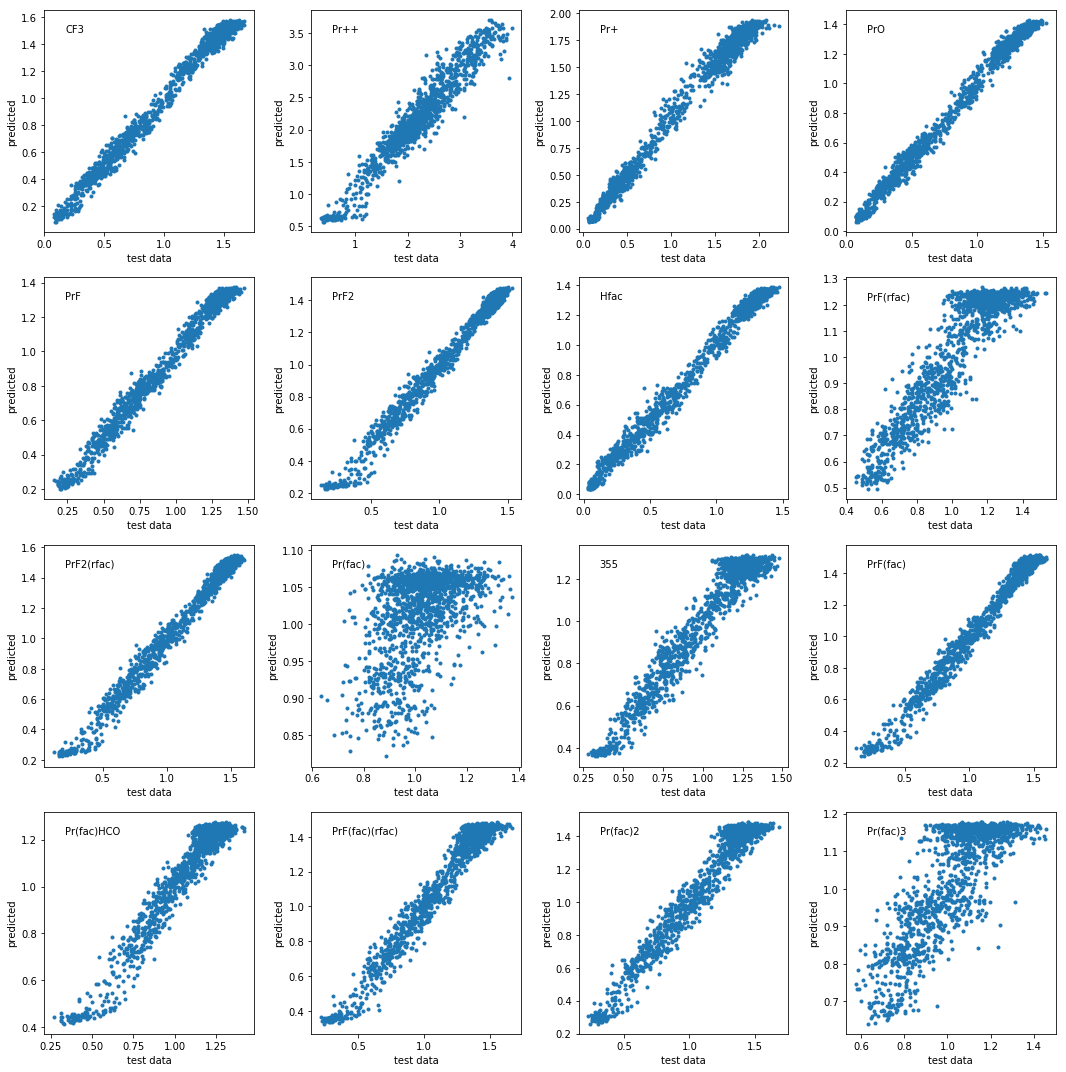


train loss: 0.00502309039925
test loss: 0.00648846792402
train score: 0.904592115813
test score: 0.897911520235


In [2]:
import train; reload(train)
import pickle
from keras.models import load_model

with open("tb_logs/2018-05-21_16:52:38/history.pkl", "r") as fp:
    history = pickle.load(fp)

model = load_model("tb_logs/2018-05-21_16:52:38/keras_model.h5")
train.evaluate_model(model, (Xtrain, ytrain), (Xtest, ytest), 0, 0, history, y_cols, True)

# to restart the kernel and release the gpu:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

# 6. Getting insights from the model

## 6.1 Checking the data-to-features transformation

The convolutional layers are expected to automatically extract relevant features from the input data. With the help of PCA and TSNE we could visualize whether this transformation aids in separating the data into classes.

### Gathering needed information

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model

df = pd.read_csv("data/processed_data.csv")
x_cols = [x for x in df.columns if ("pixel" in x)]
X = df[x_cols].values
y_cols = [x for x in df.columns if ("pixel" not in x) and ("SHG" not in x)]
y = df[y_cols].values
print X.shape, y.shape

X = np.exp(1j * X)
X = [np.real(X), np.imag(X)]
X = np.swapaxes(X, 0, -1)
X = np.swapaxes(X, 0, 1)
print X.shape

model = load_model("tb_logs/2018-05-21_16:52:38/keras_model.h5")

Using TensorFlow backend.


(7607, 160) (7607, 16)
(7607, 160, 2)


### Get the outputs after the 'flatten' layer

In [3]:
from keras.models import Model


layer_name = "flatten"
intermediate_layer_model = Model(inputs=model.input,
                                outputs=model.get_layer(layer_name).output)
X_flatten = intermediate_layer_model.predict(X)
print X_flatten.shape

(7607, 80)


### Visualize with PCA

Text(0.5,0,'eigenvector index')

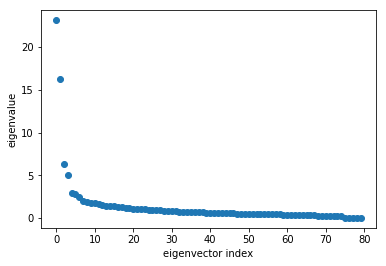

In [4]:
from sklearn.decomposition import PCA


pca = PCA(n_components=80)
Xpca = pca.fit_transform(X_flatten)
plt.plot(pca.singular_values_, 'o')
plt.ylabel('eigenvalue')
plt.xlabel('eigenvector index')

Taking up to the 50th eigenvector here does take most of the contributions as a good input for TSNE. Just to vizualize, will plot with the two leading eigenvectors.

Text(38.4129,0.5,'X2')

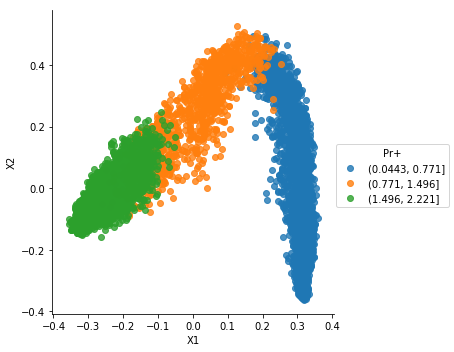

In [5]:
Xpca = PCA(n_components=2).fit_transform(X_flatten)

# scatter plot:
df_temp = pd.DataFrame(data=Xpca, columns=['X1', 'X2'])
df_temp['Pr+'] = pd.cut(df['Pr+'], bins=3)
sns.lmplot('X1', 'X2', data=df_temp, hue='Pr+', fit_reg=False)
plt.xlabel("X1")
plt.ylabel("X2")

### Visualize with TSNE

Text(37.3917,0.5,'X2')

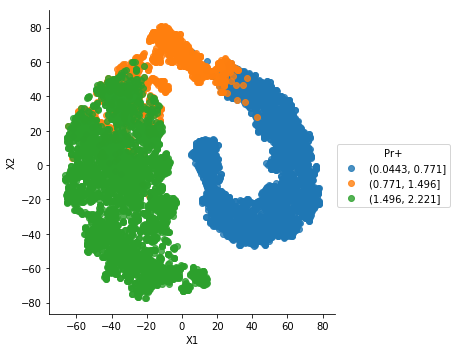

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Xpca = PCA(n_components=50).fit_transform(X_flatten)
Xtsne = TSNE(n_components=2).fit_transform(Xpca)

# scatter plot:
df_temp = pd.DataFrame(data=Xtsne, columns=['X1', 'X2'])
df_temp['Pr+'] = pd.cut(df['Pr+'], bins=3)
sns.lmplot('X1', 'X2', data=df_temp, hue='Pr+', fit_reg=False)
plt.xlabel("X1")
plt.ylabel("X2")

Text(37.3733,0.5,'X2')

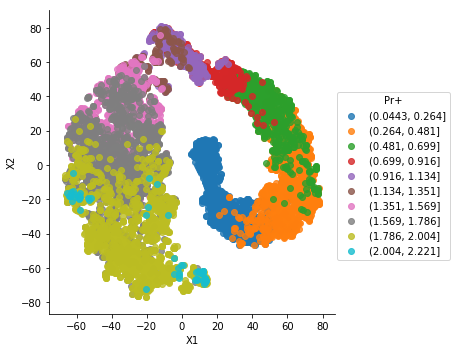

In [8]:
# scatter plot:
df_temp = pd.DataFrame(data=Xtsne, columns=['X1', 'X2'])
df_temp['Pr+'] = pd.cut(df['Pr+'], bins=10)
sns.lmplot('X1', 'X2', data=df_temp, hue='Pr+', fit_reg=False)
plt.xlabel("X1")
plt.ylabel("X2")

Text(36.5117,0.5,'X2')

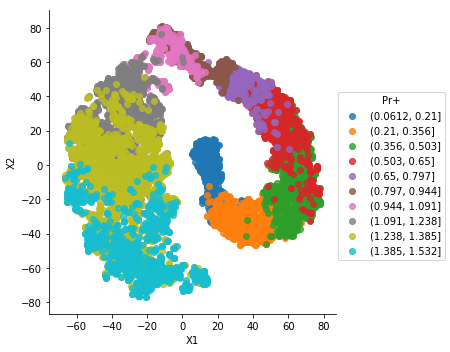

In [9]:
# scatter plot:
df_temp = pd.DataFrame(data=Xtsne, columns=['X1', 'X2'])
df_temp['Pr+'] = pd.cut(df['PrO'], bins=10)
sns.lmplot('X1', 'X2', data=df_temp, hue='Pr+', fit_reg=False)
plt.xlabel("X1")
plt.ylabel("X2")

In [ ]:
for j, frag_name in enumerate(y_cols):
    # scatter plot:
    df_temp = pd.DataFrame(data=Xtsne, columns=['X1', 'X2'])
    df_temp[frag_name] = pd.cut(df[frag_name], bins=10)
    sns.lmplot('X1', 'X2', data=df_temp, hue=frag_name, fit_reg=False)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

- The transformation from X to X_flatten does aid in separating the data. 
- As seen before when visualizing directly from X, TSNE performs better than PCA. 
- The data tends to group along a spiral-like shape in the (X1, X2) space, and the values of the various signals distribute along the spiral in characteristic ways.
- The heavier the molecular fragment, the less signal separation. This seems to simply follow the amount of noise in the corresponding labels. The heavier fragments tended to correspond to noisier signals.

## 6.2 Optimal neuron activations

Having a trained model will be useful for offline inquiries. This is particularly important since, as shown above, the experimental setup is not stable over time and, thus, measurements must be finished within a relatively narrow time window.

Here we use the trained CNN model to attempt the extraction of physical insights from the trained model. Since CNNs are able to automatically extract features from the data, there is high value in extracting those features from the model. We are currently working on perturbational algorithms that may lead to tapping those learned features. At this point, a feasible way for extracting insights may be to invert the model by finding the inputs that optimally activate output neurons. An analysis of the inverted activations could provide with field shapes of physical significance.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model

cols = pd.read_csv("data/processed_data.csv").columns
y_cols = [x for x in cols if ("pixel" not in x) and ("SHG" not in x)]
model = load_model("tb_logs/2018-05-21_16:52:38/keras_model.h5")

Using TensorFlow backend.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


### Optimize each fragment signal while reducing the others

While it is possible to optimize each output directly, one may end up maximizing aspects common to all the signal labels. In order to better characterize the individual fragments, we will attempt to obtain activations that maximize each individual fragment while at the same time reducing all others.

In [ ]:
import h5py
import os
from ga import ga

file_path = "data/optimum_activations.h5"


def fitness(X, frag_index=2):
    XX = np.vstack((np.ravel(X)[:160], np.ravel(X)[160:])).T
    XX = XX[np.newaxis, ...]
    sigs = model.predict(XX).ravel()
    J = sigs[frag_index]
    J -= np.mean(np.delete(sigs, frag_index)) # minus other fragments' mean
    J -= 0.05 * np.mean(np.abs(X)) # penalize complexity in X
    return J


for frag_indx, frag_name in enumerate(y_cols):
    ga_engine = ga.main(
        fitness_function=lambda x: fitness(x, frag_indx),
        population_size=80,
        parameters_per_individual=320,
        parameter_bounds=(-1, 1),
        mutation_rate=0.05,#0.02,
        crossover_rate=0.8,
        freq_stats=1000,
        max_gens=10000,
        callback_functions=[],
        optimization_type='maximize',
        temp_fname='.__fitness_history__.csv',
        stop_fname='.stop'
    )
    
    best = ga_engine.bestIndividual()
    best = np.array(best.genomeList)
    
    with h5py.File(file_path, "a") as fp:
        fp[frag_name] = np.vstack((np.ravel(best)[:160], np.ravel(best)[160:])).T
    
    print frag_name
    plt.plot(np.arange(0, 640, 4), np.ravel(best)[:160], label='real')
    plt.plot(np.arange(0, 640, 4), np.ravel(best)[160:], label='imag')
    plt.legend(loc='best')
    plt.xlabel("pixel")
    plt.ylabel("optimum activation")
    plt.show()
    ga.plotFitnessHistory()
    plt.show()
    
    if os.path.exists("ga/.stop"): break
        
print "model activations saved to {}".format(file_path)

The activations above have a complex structure, which makes them hard to interpret. To better visualize the optimum activations we will transform them to a wavelet representation. 

Wavelets separate a signal into component scales, which can be used as part of a divide and conquer strategy. We start by gathering needed information about the laser spectrum.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Get the laser spectrum

Text(0.5,1,'experimental laser spectrum')

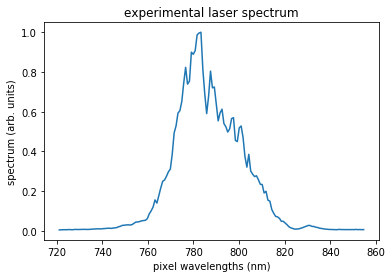

In [11]:
# get the laser spectrum data
# spec[:,0] -> wavelengths, spec[:, 1] -> spectrum
spec = np.loadtxt("data/laser_spectrum.txt")

# map the pixels to wavelenghts
pix2nm = 0.20971518772 # nm, spectral interval corresponding to one pixel
npixels = 640 # total number of pixels
central_wav = 788.322302082 # wavelength corresponding to pixel 320
pixel_wavelengths = (central_wav - pix2nm * npixels / 2.) + pix2nm * np.arange(npixels)
pixel_wavelengths = pixel_wavelengths[::4] # pixels were bundled in the experiments

# interpolate the spectrum at the pixels
spectrum = np.interp(pixel_wavelengths, spec[:, 0], spec[:, 1])

# normalize to maximum = 1
spectrum /= np.max(spectrum)

plt.plot(pixel_wavelengths, spectrum)
plt.xlabel("pixel wavelengths (nm)")
plt.ylabel("spectrum (arb. units)")
plt.title("experimental laser spectrum")

### Get the reference laser phase

This is a phase used to compensate for distortions as the laser travels through the experimental setup.

Text(0.5,1,'reference laser phase')

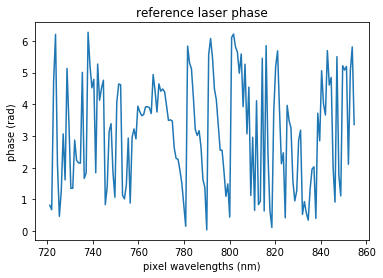

In [16]:
df_raw = pd.read_csv("data/raw_lab_data.csv")
ref_arg = df_raw['SHG'].argmax()
x_cols = [x for x in df_raw.columns if ("pixel" in x)][::4]
ph_ref = df_raw[x_cols].iloc[ref_arg].values
plt.plot(pixel_wavelengths, ph_ref)
plt.xlabel("pixel wavelengths (nm)")
plt.ylabel("phase (rad)")
plt.title("reference laser phase")

### Helper functions

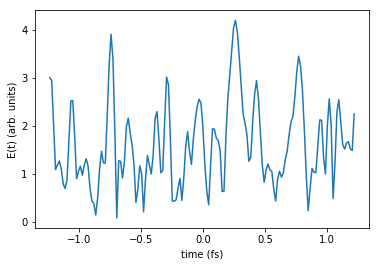

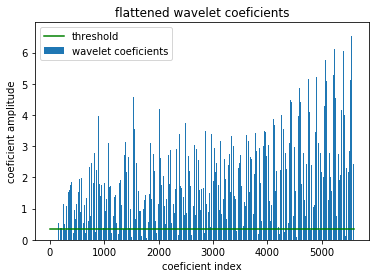

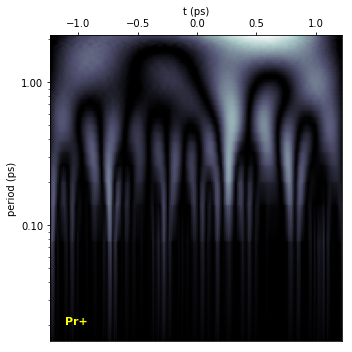

In [20]:
from scipy import constants
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as colors
import h5py


file_path = "data/optimum_activations.h5"


def slm_mask_to_et( # this is an approximation
    mask=[[]], 
    spectrum=[],
    npixels=640,
    central_wav=788.322302082,
    pix2nm=0.20971518772,
    ref_phase=[],
):
    c = constants.c * 1e9 / 1e12 # speed of light in nm/ps
    N = np.shape(mask)[0]
    nbundling = int(float(npixels) / N)
    df = c * (1. / central_wav - 1. / (central_wav + nbundling * pix2nm))
    t = np.fft.fftfreq(N) / df
    t = np.fft.fftshift(t)
    dt = t[1] - t[0]
    
    m = mask[:, 0] + 1j * mask[:, 1]
    elambda = spectrum * np.abs(m) * np.exp(1j * (np.angle(m) - ref_phase))
    et = np.fft.ifft(np.fft.ifftshift(elambda))
    et = np.fft.fftshift(et)
    et *= N * df
    
    return t, et


def et_to_wavelet(
    et=[],
    dt=1,
    scales=np.arange(0.25, 35)
):
    coef, freqs = pywt.cwt(et, scales, 'mexh', sampling_period=dt)
    periods = 1. / freqs
    
    return periods, coef


def threshold_wavelet(coefs, 
                      ratio_from_max=0.05):
    thres = np.max(np.abs(coefs)) * ratio_from_max
    thres_coefs = pywt.threshold(
        data=coefs, 
        value=thres, 
        mode='soft',
        substitute=0
    )
    return thres_coefs, thres


def plot_fragment_wavelet(
    t, periods, coefs,
    k=0, frag_name='Pr+',
    nrows=1, ncols=1,
    figname="wavelets",
    figsize=(15, 15)
):
    plt.figure(figname, figsize=figsize)
    plt.subplot(nrows, ncols, k + 1)
    plt.pcolormesh(t, periods, np.abs(coefs), cmap='bone',# 'PRGn', 
                   shading='gouraud')#, vmin=coef.min(), vmax=coef.max())
    plt.yscale('log')
    ax = plt.gca()
    ax.text(0.05, 0.05, frag_name,
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='yellow', fontsize=11, weight='bold')
    
    # to plot the fragment wavelet along others on a grid:
    # y ticks and labels:
    if np.mod(k, ncols) == 0:
        plt.ylabel('period (ps)')
    elif np.mod(k, ncols) == 3:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        plt.ylabel('period (ps)')
    else:
        ax.set_yticks([])
        plt.ylabel('')
    plt.ylim((np.min(periods), np.max(periods)))

    # x ticks and labels:
    if k < nrows:
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        plt.xlabel('t (ps)')
    elif k >= (nrows - 1) * ncols:
        plt.xlabel('t (ps)')
    else:
        ax.set_xticks([])
        plt.xlabel('')
    
    ax.get_yaxis().set_major_formatter(ScalarFormatter())

    plt.tight_layout()


# test the functions:
frag_name = "Pr+"

with h5py.File(file_path, 'r') as fp:
    mask = fp[frag_name][...]

t, et = slm_mask_to_et(
    mask=mask, 
    spectrum=spectrum,
    npixels=640,
    central_wav=788.322302082,
    pix2nm=0.20971518772,
    ref_phase=ph_ref,
)
et = np.abs(et)

dt = t[1] - t[0]
periods, coefs = et_to_wavelet(
    et=et,
    dt=dt,
    scales=np.arange(0.25, 35)
)
thres_coefs, thres = threshold_wavelet(coefs, 0.05)

plt.figure('et')
plt.plot(t, et)
plt.xlabel("time (fs)")
plt.ylabel("E(t) (arb. units)")

plt.figure('flattened wavelet')
flat_coefs = np.ravel(np.abs(coefs))
plt.bar(range(len(flat_coefs)), flat_coefs, 
        label='wavelet coeficients')
plt.plot([0, len(flat_coefs)], [thres, thres], 'g', label='threshold')
plt.legend(loc='best')
plt.title("flattened wavelet coeficients")
plt.xlabel("coeficient index")
plt.ylabel("coeficient amplitude")

plot_fragment_wavelet(
    t, periods, thres_coefs,
    k=0, frag_name=frag_name,
    nrows=1, ncols=1,
    figname="wavelets",
    figsize=(5, 5)
)

### Wavelet representation of the optimum activations

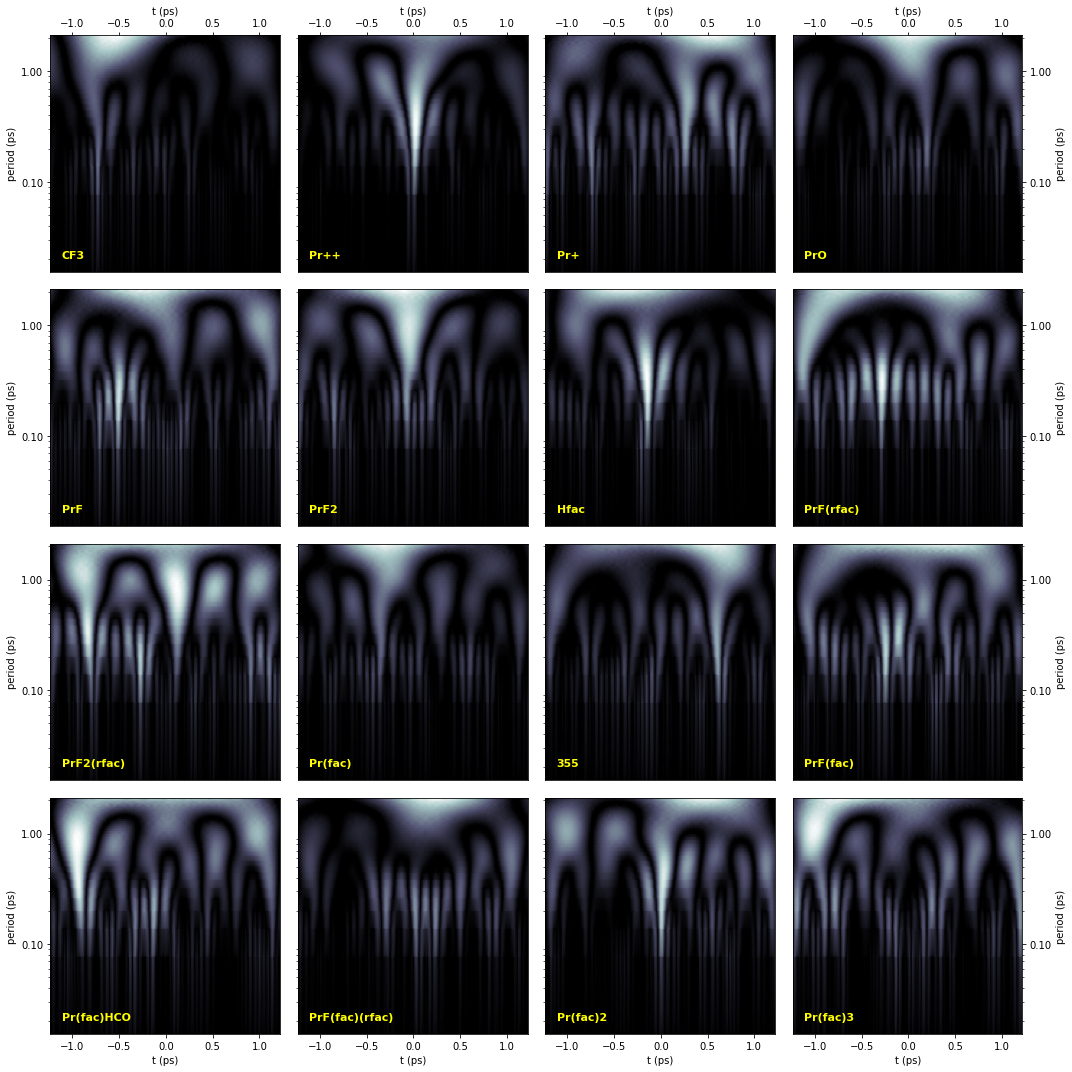

In [21]:
from scipy import constants
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as colors


file_path = "data/optimum_activations.h5"
cols = pd.read_csv("data/processed_data.csv").columns
y_cols = [x for x in cols if ("pixel" not in x) and ("SHG" not in x)]

for frag_indx, frag_name in enumerate(y_cols):
    with h5py.File(file_path, 'r') as fp:
        mask = fp[frag_name][...]
    
    # to time domain:
    t, et = slm_mask_to_et(
        mask=mask, 
        spectrum=spectrum,
        npixels=640,
        central_wav=788.322302082,
        pix2nm=0.20971518772,
        ref_phase=ph_ref,
        )
    et = np.abs(et)
    
    # to wavelet:
    dt = t[1] - t[0]
    periods, coefs = et_to_wavelet(
        et=et,
        dt=dt,
        scales=np.arange(0.25, 35)
    )
    thres_coefs, thres = threshold_wavelet(coefs, 0.05)
    
    plot_fragment_wavelet(
        t, periods, thres_coefs,
        k=frag_indx, frag_name=frag_name,
        nrows=4, ncols=4,
        figname="wavelets",
        figsize=(15, 15)
    )

### Mechanistic considerations

The ultrafast fragmentation of Pr(fac)$_3$ is a complex phenomenon that includes processes such as: metal-ligand (i.e. metal=Pr, ligand=(fac)) charge transfer, CF$_3$ elimination, C-C (C=Carbon) bond rotation, and molecular reconformation yielding PrF or PrO. Some of these processes collaborate, while others compete with each other. For instance, while most processes are initiated by charge transfer, CF$_3$ elimination competes with C-C bond rotation. 

Many optimum activations show clear oscillations with ~0.3 ps period which may reflect the effects of bond rotation. These oscillations are somewhat suppressed for the CF$_3$ fragment, whose origin seems to be overwhelmingly related to CF$_3$ elimination. 

A difference between the single ionized Pr$^+$ and the doubly ionized Pr$^{++}$ activations appears to be that the activation for Pr$^{++}$ tends to concentrate its intensity around t = 0 ps. This suggest that double ionization occurs here as a high-intensity impulsive process that 'liberates' Pr at once from all its ligands by simultaneous CF$_3$ eliminations and resulting in two of the ligands leaving with an extra electron. On the other hand, the formation of Pr$^+$ does not seem to necesitate exclusively relying on such a sudden mechanism and appears, instead, to also have contributions from C-C bond rotation.

More insights may be extracted from coupling the data analysis above with the results of other published research findings, an effort that is currently underway.

# 7. Conclusions

A deep convolutional neural network (CNN) was trained on ultrafast laser molecular fragmentation data. The process started with the identification of an appropriate experimental sampling procedure due to random sampling performing poorly. The collected data had to be heavily processed due to the effects of non-stable experimental conditions. The resulting dataset was then explored (to determine, among other things, whether a linear model could be appropriate to fit the data) and then used to train the CNN. Internal outputs of the trained and validated CNN model were also explored to observe how the model transformed the inputs in trying to predict the labels. Optimal output neuron activations were then extracted from the model by inverting it using a genetic algorithm. The structural features of some of the inverted activations were then discussed in terms of the physical processes that take place during the molecular fragmentation of Pr(fac)$_3$.

Notice that under current technological limitations it is sometimes prohibitely difficult to extract insights from even a modest-sized molecule such as Pr(fac)$_3$ by either experimental methods or through simulations. Leveraging trained machine learning models for the study of physical, chemical or biological systems may have important ramifications in science and technology.